# Useful libraries

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the tree class and the associated methods

In [3]:
class Tree:
    def __init__(self, idx, depth=0, nbVisit=0, tot=0, bound=1e9, father=None, leftChild=None, rightChild=None, leaf=None):
        self.idx = idx
        self.depth=depth
        self.nbVisit = nbVisit
        self.tot = tot
        self.bound = bound
        self.father = father
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.leaf = leaf
    
    
    def __str__(self):
        res = """Id: {}\nDepth: {}\nNumber of visits: {}\nSum of rewards: {}\nCurrent upper bound: {}\nLeaf: {}\n
        """.format(self.idx, self.depth, self.nbVisit, self.tot, self.bound, str(self.leaf))
        return res
    
    
    def build(self, fatherDict, childrenDict, leafDict):
        nodeList = [self]
        nbNodes = len(fatherDict)+1
        # set fathers and children
        for i in range(1, nbNodes):
            nodeList.append(Tree(i, depth=nodeList[fatherDict[i]].depth+1, father=nodeList[fatherDict[i]]))
        # set children
        for i in childrenDict:
            nodeList[i].leftChild = nodeList[childrenDict[i][0]]
            nodeList[i].rightChild = nodeList[childrenDict[i][1]]
        # set leaves
        for i in leafDict:
            nodeList[i].leaf = leafDict[i]
        leafList = [e for e in nodeList if e.idx in leafDict]
        return nodeList, leafList
    
    
    def build_comb(self, D):
        d = self.depth
        if d == D-1:
            lC = Tree(idx=self.idx+1, depth=d+1, father=self, leaf=ConstantLeaf(0))
            rC = Tree(idx=self.idx+2, depth=d+1, father=self, leaf=ConstantLeaf(1))
            self.leftChild = lC
            self.rightChild = rC
        else:
            lC = Tree(idx=self.idx+1, depth=d+1, father=self, leaf=ConstantLeaf((D-d-1)/D))
            rC = Tree(idx=self.idx+2, depth=d+1, father=self)
            self.leftChild = lC
            self.rightChild = rC
            self.rightChild.build_comb(D)
    
    
    def build_smooth(self, D, inf=0, sup=1, delta=1, gamma=0.5):
        if self.depth == D:
            self.leaf = BernoulliLeaf(p=inf+(sup-inf)*np.random.rand())
        
        else:
            radius = delta*gamma**(self.depth)/2
            new_center = inf + (sup-inf)*np.random.rand()
            if new_center - radius < inf:
                new_inf = inf
                new_sup = new_inf + 2*radius
            elif new_center + radius > sup:
                new_sup = sup
                new_inf = new_sup - 2*radius
            else:
                new_inf = new_center - radius
                new_sup = new_center + radius
            self.leftChild = Tree(idx=self.idx+1, depth=self.depth+1, father=self)
            self.rightChild = Tree(idx=self.idx+2**(D-self.depth), depth=self.depth+1, father=self)
            self.leftChild.build_smooth(D, new_inf, new_sup, delta, gamma)
            self.rightChild.build_smooth(D, new_inf, new_sup, delta, gamma)
    
    
    def build_bernoulli(self, p, maxD):
        u = np.random.rand()
        if ((u < p) or (self.depth == 0)) and (self.depth < maxD):
            self.leftChild = Tree(0, depth=self.depth+1, father=self)
            self.rightChild = Tree(0, depth=self.depth+1, father=self)
            self.leftChild.build_bernoulli(p, maxD)
            self.rightChild.build_bernoulli(p, maxD)
        else:
            m = np.random.rand()
            self.leaf = BernoulliLeaf(m)
    
    
    
    def UCT_update(self, r, bound_function, visited=True):
        if visited:
            self.tot += r
            self.nbVisit += 1
        if (self.father != None) and (self.nbVisit > 0):
            self.bound = self.tot/self.nbVisit + bound_function(self.nbVisit, self.father.nbVisit)
    
    
    def modifiedUCT_update(self, r, D, beta, bound_function):
        self.tot += r
        self.nbVisit += 1
        if self.father != None:
            self.bound = self.tot/self.nbVisit + bound_function(D, self.depth, self.nbVisit, beta)
    
    
    def flatUCT_update(self, r, D, beta, bound_function):
        self.nbVisit += 1
        if self.leaf == None:
            self.bound = np.max([self.leftChild.bound, self.rightChild.bound])
        else:
            self.tot += r
            self.bound = self.tot/self.nbVisit + bound_function(D, self.nbVisit, beta)
    
    
    def smooth_update(self, r, D, beta, delta, gamma, bound_function):
        self.tot += r
        self.nbVisit += 1
        n = self.nbVisit
        c = bound_function(n, D, beta)
        if self.leaf == None:
            delta_d = delta*gamma**(self.depth)
            self.bound = min(max(self.leftChild.bound, self.rightChild.bound),
                            self.tot/self.nbVisit + delta_d + c)
        else:
            self.bound = self.tot/self.nbVisit + c
    
    
    def find_best_arm(self):
        if self.leaf == None:
            return max(self.leftChild.find_best_arm(), self.rightChild.find_best_arm())
        else:
            return self.leaf.p
    
    
    def find_depth(self):
        if self.leaf == None:
            return max(self.leftChild.find_depth(), self.rightChild.find_depth())
        else:
            return self.depth

# Define different classes of leaves

In [4]:
class NormalLeaf:
    def __init__(self, p, std):
        self.p = p
        self.std = std
    
    def __str__(self):
        return "Normal distribution with mean {} and standard deviation {}".format(self.p, self.std)
    
    def sample(self):
        return np.random.normal(self.p, self.std)


class BernoulliLeaf:
    def __init__(self, p):
        self.p = p
    
    def __str__(self):
        return "Bernoulli distribution with parameter {}".format(self.p)
    
    def sample(self):
        return np.random.binomial(1, self.p)


class ConstantLeaf:
    def __init__(self, p):
        self.p = p
    
    def __str__(self):
        return "This leaf returns a constant value {}".format(self.p)
    
    def sample(self):
        return self.p

# The UCT algorithm

In [5]:
def UCT_bound_function_log(n, p):
    return np.sqrt(2*np.log(p)/n)


def UCT_bound_function_sqrt(n, p):
    return np.sqrt(np.sqrt(p)/n)


def modifiedUCT_bound_function(D, d, n, beta):
    kd = (1 + np.sqrt(2))/np.sqrt(2)*((1 + np.sqrt(2))**(D-d) - 1)
    kdprime = (3**(D-d) - 1)/2
    N = 2**(D+1) - 1
    betan = beta/(2*N*n*(n+1))
    res = (kd + 1)*np.sqrt(np.log(1/betan)/(2*n))+ kdprime/n
    return res


def flatUCT_bound_function(D, n, beta):
    betan = beta/(2**(D+1)*n*(n+1))
    res = np.sqrt(np.log(1/betan)/(2*n))
    return res


def smooth_bound_function(n, D, beta):
    N = 2**(D+1) - 1
    return np.sqrt(2*np.log(N*n*(n+1)/beta)/n)


def UCT(root, N_iter, bound_function, mode='classic', D=0, beta=0.05, delta=1, gamma=0.5):
    
    # Reward
    R = 0
    Rlist = [0]
    # N_iter paths
    for i in range(N_iter):
        currentNode = root
        
        # sample a trajectory
        traj = [root]
        traj_not_visited = [] # nodes whose father is in the trajectory must be updated
        while currentNode.leaf == None:
            if currentNode.leftChild.bound < currentNode.rightChild.bound:
                traj_not_visited.append(currentNode.leftChild)
                currentNode = currentNode.rightChild
            else:
                traj_not_visited.append(currentNode.rightChild)
                currentNode = currentNode.leftChild
            traj.append(currentNode)
        
        # once in a leaf, sample a reward
        r = currentNode.leaf.sample()
        R += r
        Rlist.append(R)
        # update the whole trajectory
        if mode == 'classic':
            for node in traj:
                node.UCT_update(r, bound_function)
            for node in traj_not_visited:
                node.UCT_update(r, bound_function, visited=False)
        elif mode == 'modified':
            for node in traj:
                node.modifiedUCT_update(r, D, beta, bound_function)
        elif mode == 'flat':
            for node in reversed(traj):
                node.flatUCT_update(r, D, beta, bound_function)
        elif mode == 'smooth':
            for node in reversed(traj):
                node.smooth_update(r, D, beta, delta, gamma, bound_function)
                
        
    # find the best path
    currentNode = root
    path = [root]
    while currentNode.leaf == None:
        if currentNode.leftChild.bound < currentNode.rightChild.bound:
            currentNode = currentNode.rightChild
        else:
            currentNode = currentNode.leftChild
        path.append(currentNode)
    
    return R, Rlist, path

# Plot the regrets of different algorithms

In [12]:
def compare_regrets(cumR_list, legend):
    plt.figure(figsize=(10,10))
    for Rl in cumR_list:
        plt.plot(np.array(Rl))
    plt.legend(legend)
    plt.title('Cumulative regret with respect to iterations')
    plt.show()

In [4]:
'''root = Tree(0)
fDict = {1: 0,
         2: 0,
         3: 1,
         4: 1,
         5: 2,
         6: 2}

cDict = {0: (1, 2),
         1: (3, 4),
         2: (5, 6)}

lDict = {3: NormalLeaf(0, 2),
         4: NormalLeaf(0.2, 1),
         5: NormalLeaf(0.1, 0.5),
         6: NormalLeaf(-0.3, 3)}

nodeList, leafList = root.build(fDict, cDict, lDict)'''

In [5]:
root = Tree(0)
fDict = {1: 0,
         2: 0,
         3: 1,
         4: 1,
         5: 2,
         6: 2}

cDict = {0: (1, 2),
         1: (3, 4),
         2: (5, 6)}

lDict = {3: BernoulliLeaf(0.48),
         4: BernoulliLeaf(0.53),
         5: BernoulliLeaf(0.52),
         6: BernoulliLeaf(0.5)}


beta=0.5
nodeList, leafList = root.build(fDict, cDict, lDict)
N_iter = 500000
R, Rlist, path = UCT(root, N_iter, modifiedUCT_bound_function, mode='modified', D=2, beta=beta)

In [6]:
for p in nodeList:
    print(p)

Id: 0
Depth: 0
Number of visits: 500000
Sum of rewards: 262167
Current upper bound: 1000000000.0
Leaf: None

        
Id: 1
Depth: 1
Number of visits: 316206
Sum of rewards: 167331
Current upper bound: 0.5751554046750046
Leaf: None

        
Id: 2
Depth: 1
Number of visits: 183794
Sum of rewards: 94836
Current upper bound: 0.5751387877291178
Leaf: None

        
Id: 3
Depth: 2
Number of visits: 11199
Sum of rewards: 5397
Current upper bound: 0.5445698667583793
Leaf: Bernoulli distribution with parameter 0.48

        
Id: 4
Depth: 2
Number of visits: 305007
Sum of rewards: 161934
Current upper bound: 0.5446105853437121
Leaf: Bernoulli distribution with parameter 0.53

        
Id: 5
Depth: 2
Number of visits: 151015
Sum of rewards: 78447
Current upper bound: 0.5384385430030214
Leaf: Bernoulli distribution with parameter 0.52

        
Id: 6
Depth: 2
Number of visits: 32779
Sum of rewards: 16389
Current upper bound: 0.5383529710650243
Leaf: Bernoulli distribution with parameter 0.5

   

# I. UCT with log-exploration vs. UCT with sqrt-exploration

### I.1. Comb tree

UCT with log-exploration...
UCT with sqrt-exploration...


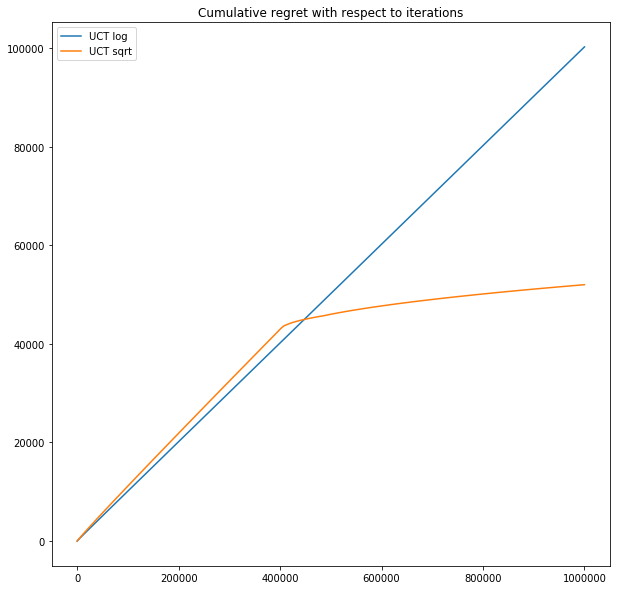

In [15]:
D = 10

print('UCT with log-exploration...')
root = Tree(0)
root.build_comb(D)
bound_function = UCT_bound_function_log
N_iter = 1000000
R1, Rlist1, path1 = UCT(root, N_iter, bound_function=bound_function, mode='classic')
best_arm_mean = root.find_best_arm()
Rlist1 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)]

print('UCT with sqrt-exploration...')
root = Tree(0)
root.build_comb(D)
bound_function = UCT_bound_function_sqrt
N_iter = 1000000
R2, Rlist2, path2 = UCT(root, N_iter, bound_function=bound_function, mode='classic')
Rlist2 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)]

cumR_list = [Rlist1, Rlist2]
best_arm_mean = 1
legend = ['UCT log', 'UCT sqrt']
compare_regrets(cumR_list, legend)

### I.2. Bernoulli-defined tree

UCT with log bound...
UCT with sqrt bound...


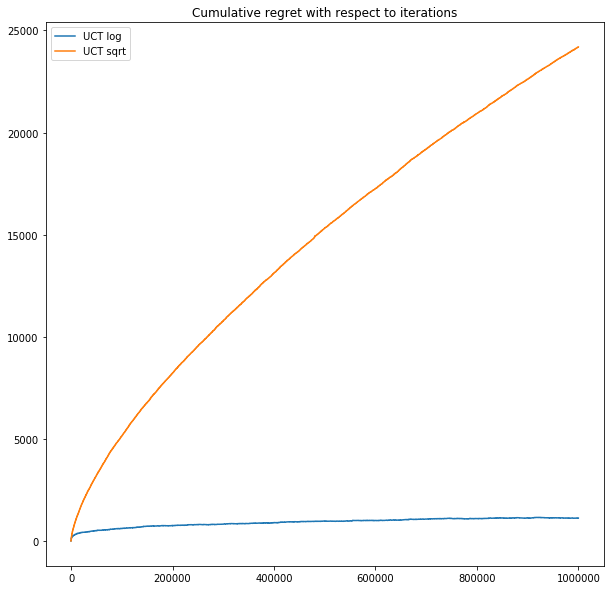

In [16]:
# Parameters
p = 0.7
maxD = 12
delta = 1
N_iter = 1000000
beta = 0.01


# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = UCT_bound_function_log
R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
best_arm_mean = root.find_best_arm()
Rlist1 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)]

print('UCT with sqrt bound...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = UCT_bound_function_sqrt
R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
best_arm_mean = root.find_best_arm()
Rlist2 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)]

cumR_list = [Rlist1, Rlist2]
legend = ['UCT log', 'UCT sqrt']
compare_regrets(cumR_list, legend)

# II. Compare all the algorithms

### II.1. On a "Bernoulli" tree

UCT with log bound...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.25s/it]


UCT with sqrt bound...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.09s/it]


Modified UCT...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.51s/it]


Flat UCT...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.20s/it]


0.8917730007820798


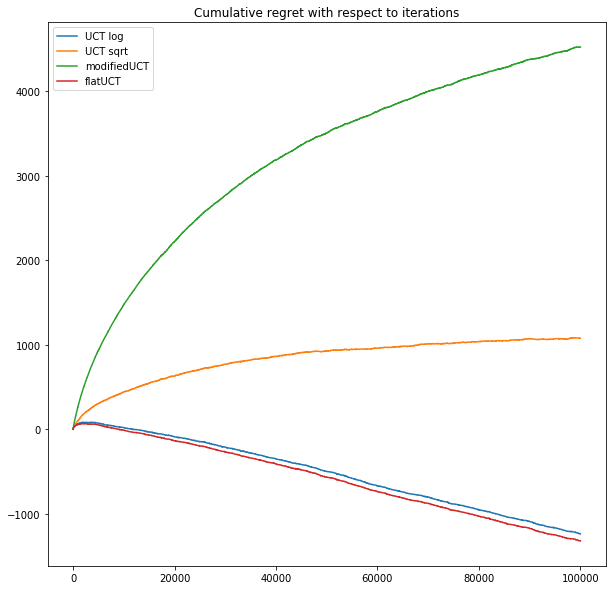

In [9]:
# Parameters
p = 0.7
maxD = 4
delta = 1
N_iter = 100000
beta = 0.01
N_sim = 10

# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
Rlist1_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = UCT_bound_function_log
    R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist1_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)])
Rlist1_mean = np.mean(Rlist1_mean, axis=0)

print('UCT with sqrt bound...')
np.random.seed(0)
Rlist2_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = UCT_bound_function_sqrt
    R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist2_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)])
Rlist2_mean = np.mean(Rlist2_mean, axis=0)

print('Modified UCT...')
np.random.seed(0)
Rlist3_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = modifiedUCT_bound_function
    R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist3_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist3)])
Rlist3_mean = np.mean(Rlist3_mean, axis=0)

print('Flat UCT...')
np.random.seed(0)
Rlist4_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = flatUCT_bound_function
    R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist4_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist4)])
Rlist4_mean = np.mean(Rlist4_mean, axis=0)

cumR_list = [Rlist1_mean, Rlist2_mean, Rlist3_mean, Rlist4_mean]
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT']
compare_regrets(cumR_list, legend)

0.9944007896476794


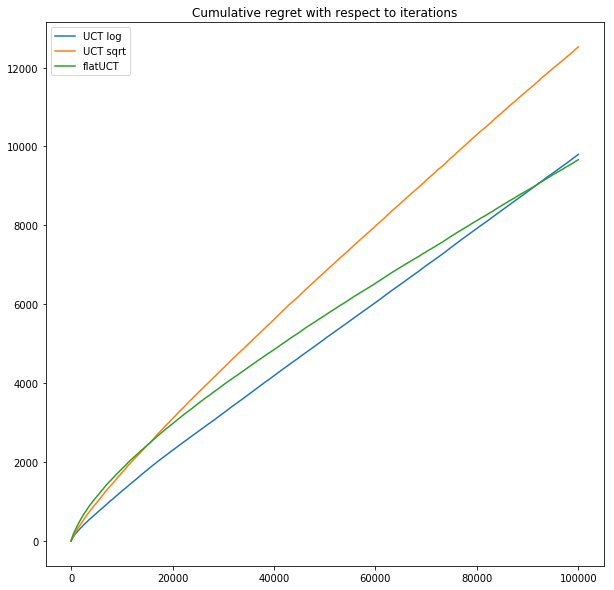

In [13]:
cumR_list = [Rlist1_mean, Rlist2_mean, Rlist4_mean]
legend = ['UCT log', 'UCT sqrt', 'flatUCT']
compare_regrets(cumR_list, legend)

### II.2. On a smooth tree

In [ ]:
# Parameters
D = 6
delta = 1
gamma = 0.01
beta = 0.05
N_iter = 1000000
N_sim = 10

# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
Rlist1_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = UCT_bound_function_log
    R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist1_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)])
Rlist1_mean = np.mean(Rlist1_mean, axis=0)

print('UCT with sqrt bound...')
np.random.seed(0)
Rlist2_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = UCT_bound_function_sqrt
    R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist2_mean.append([best_arm_mean*(i+1)-e for e in enumerate(Rlist2)])
Rlist2_mean = np.mean(Rlist2_mean, axis=0)

print('Modified UCT...')
np.random.seed(0)
Rlist3_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = modifiedUCT_bound_function
    R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist3_mean.append([best_arm_mean*(i+1)-e for e in enumerate(Rlist3)])
Rlist3_mean = np.mean(Rlist3_mean, axis=0)

print('Flat UCT...')
np.random.seed(0)
Rlist4_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = flatUCT_bound_function
    R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist4_mean.append([best_arm_mean*(i+1)-e for e in enumerate(Rlist4)])
Rlist4_mean = np.mean(Rlist4_mean, axis=0)

print('Bandit for smooth tree...')
np.random.seed(0)
Rlist5_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = smooth_bound_function
    R5, Rlist5, path5 = UCT(root, N_iter, bound_function, mode='smooth', D=D, beta=beta, delta=delta, gamma=gamma)
    best_arm_mean = root.find_best_arm()
    Rlist5_mean.append([best_arm_mean*(i+1)-e for e in enumerate(Rlist5)])
Rlist5_mean = np.mean(Rlist5_mean, axis=0)

cumR_list = [Rlist1_mean, Rlist2_mean, Rlist3_mean, Rlist4_mean, Rlist5_mean]
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT', 'smooth bandit']
compare_regrets(cumR_list, legend)

UCT with log bound...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:02<00:00, 90.25s/it]


UCT with sqrt bound...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:32<00:00, 81.30s/it]


Modified UCT...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:42<00:00, 118.25s/it]


Flat UCT...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:33<00:00, 93.32s/it]


Bandit for smooth tree...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0.885294759540014


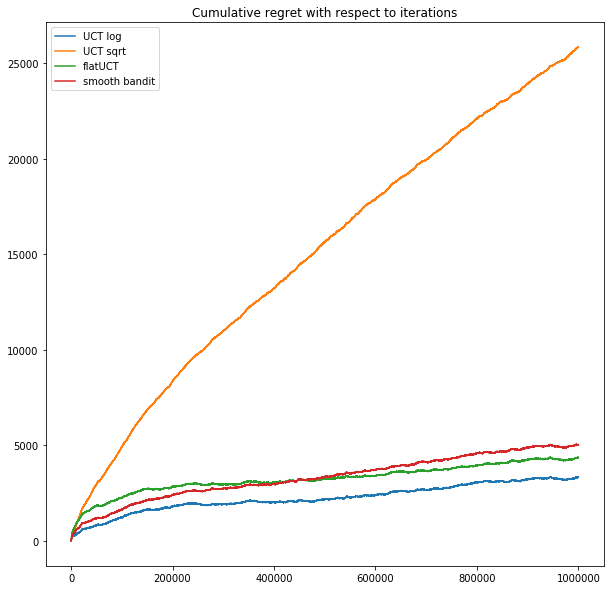

In [145]:
cumR_list = [Rlist1, Rlist2, Rlist4, Rlist5]
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
best_arm_mean = root.find_best_arm()
print(best_arm_mean)
legend = ['UCT log', 'UCT sqrt', 'flatUCT', 'smooth bandit']
compare_regrets(cumR_list, best_arm_mean, legend)

In [111]:
D = 50
beta = 0.01

In [112]:
root = Tree(0)
root.build_comb(D)
bound_function = UCT_bound_function_log
N_iter = 1000000
R1, Rlist1, path1 = UCT(root, N_iter, bound_function=bound_function, mode='classic')

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:10<00:00, 98492.83it/s]


In [113]:
root = Tree(0)
root.build_comb(D)
bound_function = UCT_bound_function_sqrt
N_iter = 1000000
R2, Rlist2, path2 = UCT(root, N_iter, bound_function=bound_function, mode='classic')

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:11<00:00, 83937.16it/s]


In [114]:
root = Tree(0)
root.build_comb(D)
bound_function = modifiedUCT_bound_function
N_iter = 1000000
R3, Rlist3, path3 = UCT(root, N_iter, modifiedUCT_bound_function, mode='modified', D=D, beta=beta)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:12<00:00, 83021.61it/s]


In [115]:
root = Tree(0)
root.build_comb(D)
bound_function = flatUCT_bound_function
N_iter = 1000000
R4, Rlist4, path4 = UCT(root, N_iter, flatUCT_bound_function, mode='flat', D=D, beta=beta)

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [04:57<00:00, 3359.91it/s]


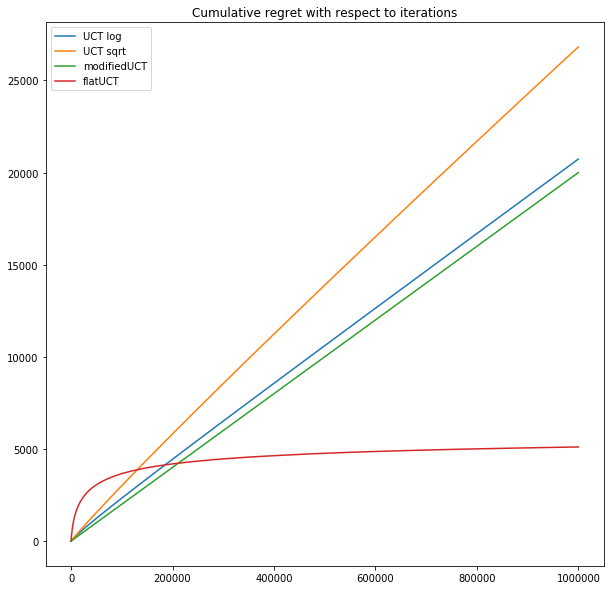

In [116]:
cumR_list = [Rlist1, Rlist2, Rlist3, Rlist4]
best_arm_mean = 1
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT']
compare_regrets(cumR_list, best_arm_mean, legend)

In [70]:
root = Tree(0)
root.build_comb(D)
beta=0.5
N_iter = 100000
R, Rlist, path = UCT(root, N_iter, modifiedUCT_bound_function, mode='modified', D=D, beta=beta)

In [74]:
root = Tree(0)
root.build_comb(D)
beta=0.01
N_iter = 100000
R3, Rlist3, path3 = UCT(root, N_iter, modifiedUCT_bound_function, mode='modified', D=D, beta=beta)

In [75]:
root = Tree(0)
root.build_comb(D)
beta=0.01
N_iter = 100000
R4, Rlist4, path4 = UCT(root, N_iter, flatUCT_bound_function, mode='flat', D=D, beta=beta)

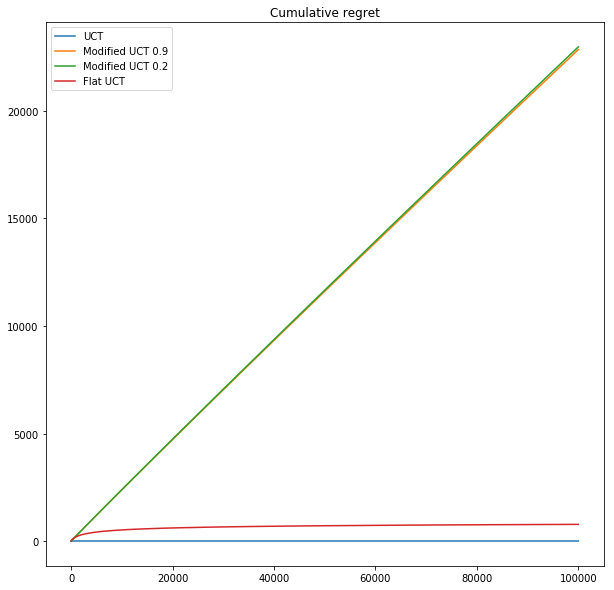

In [76]:
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(np.ones(len(Rlist2))) - np.array(Rlist2))
plt.plot(np.cumsum(np.ones(len(Rlist))) - np.array(Rlist))
plt.plot(np.cumsum(np.ones(len(Rlist3))) - np.array(Rlist3))
plt.plot(np.cumsum(np.ones(len(Rlist4))) - np.array(Rlist4))
plt.legend(['UCT', 'Modified UCT 0.9', 'Modified UCT 0.2', 'Flat UCT'])
plt.title('Cumulative regret')
plt.show()

In [118]:
# Parameters
D = 6
delta = 1
gamma = 0.01
beta = 0.05
N_iter = 1000000


# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = UCT_bound_function_log
R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)

print('UCT with sqrt bound...')
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = UCT_bound_function_sqrt
R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)

print('Modified UCT...')
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = modifiedUCT_bound_function
R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)

print('Flat UCT...')
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = flatUCT_bound_function
R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)

print('Bandit for smooth tree...')
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = smooth_bound_function
R5, Rlist5, path5 = UCT(root, N_iter, bound_function, mode='smooth', D=D, beta=beta, delta=delta, gamma=gamma)

cumR_list = [Rlist1, Rlist2, Rlist3, Rlist4, Rlist5]
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
best_arm_mean = root.find_best_arm()
print(best_arm_mean)
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT', 'smooth bandit']
compare_regrets(cumR_list, best_arm_mean, legend)

UCT with log bound...


100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:00<00:00, 16524.05it/s]


UCT with sqrt bound...


100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:50<00:00, 19666.02it/s]


Modified UCT...


100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:06<00:00, 15119.16it/s]


Flat UCT...


100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:50<00:00, 19699.64it/s]


Bandit for smooth tree...


100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:43<00:00, 23228.08it/s]


0.885294759540014


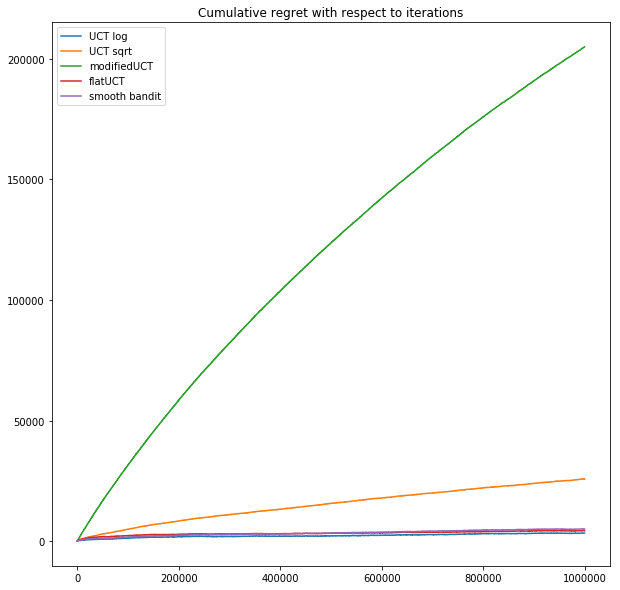

In [119]:
cumR_list = [Rlist1, Rlist2, Rlist3, Rlist4, Rlist5]
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
best_arm_mean = root.find_best_arm()
print(best_arm_mean)
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT', 'smooth bandit']
compare_regrets(cumR_list, best_arm_mean, legend)

0.885294759540014


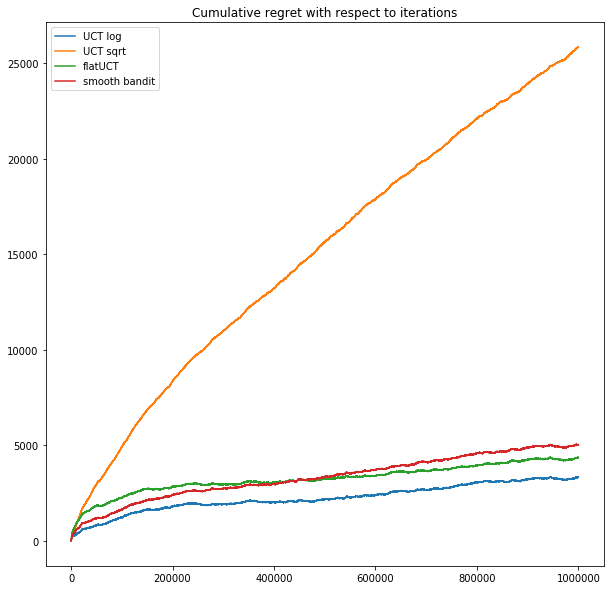

In [103]:
cumR_list = [Rlist1, Rlist2, Rlist4, Rlist5]
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
best_arm_mean = root.find_best_arm()
print(best_arm_mean)
legend = ['UCT log', 'UCT sqrt', 'flatUCT', 'smooth bandit']
compare_regrets(cumR_list, best_arm_mean, legend)

In [133]:
# Parameters
p = 0.7
maxD = 12
delta = 1
N_iter = 100000
beta = 0.01


# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = UCT_bound_function_log
R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)

print('UCT with sqrt bound...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = UCT_bound_function_sqrt
R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)

print('Modified UCT...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = modifiedUCT_bound_function
R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)

print('Flat UCT...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = flatUCT_bound_function
R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)

cumR_list = [Rlist1, Rlist2, Rlist3, Rlist4]
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
best_arm_mean = root.find_best_arm()
print(best_arm_mean)
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT']
compare_regrets(cumR_list, best_arm_mean, legend)

UCT with log bound...


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18452.09it/s]


UCT with sqrt bound...


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 19541.02it/s]


Modified UCT...


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 25310.55it/s]


Flat UCT...


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12963.83it/s]


0.9944007896476794


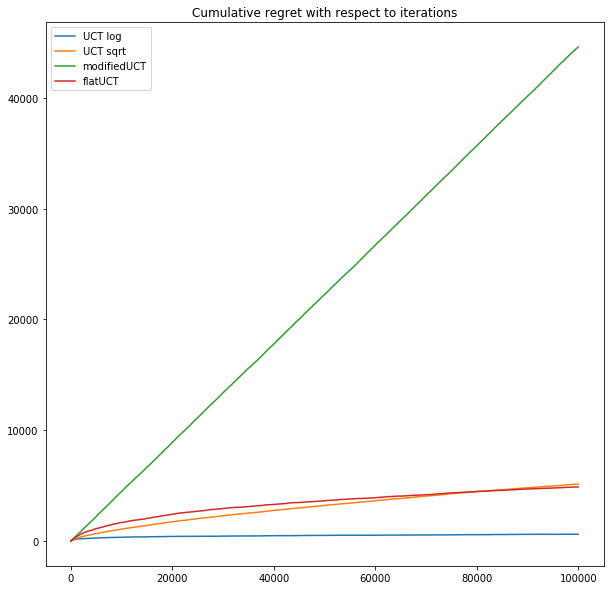

In [134]:
cumR_list = [Rlist1, Rlist2, Rlist3, Rlist4]
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
best_arm_mean = root.find_best_arm()
print(best_arm_mean)
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT']
compare_regrets(cumR_list, best_arm_mean, legend)

In [91]:
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = UCT_bound_function_log
N_iter = 1000000
R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:10<00:00, 14115.89it/s]


In [92]:
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = UCT_bound_function_sqrt
N_iter = 1000000
R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:09<00:00, 14414.15it/s]


In [93]:
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = modifiedUCT_bound_function
N_iter = 1000000
R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:21<00:00, 12288.64it/s]


In [94]:
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = flatUCT_bound_function
N_iter = 1000000
R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:12<00:00, 13862.17it/s]


In [95]:
np.random.seed(0)
root = Tree(0)
root.build_smooth(D)
bound_function = smooth_bound_function
N_iter = 1000000
R5, Rlist5, path5 = UCT(root, N_iter, bound_function, mode='smooth', D=D, beta=beta, delta=delta, gamma=gamma)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:58<00:00, 17193.32it/s]


In [89]:
for p in path3:
    print(p)

Id: 0
Depth: 0
Number of visits: 1000000
Sum of rewards: 857206
Current upper bound: 1000000000.0
Leaf: None

        
Id: 1024
Depth: 1
Number of visits: 500471
Sum of rewards: 442022
Current upper bound: 59.161929226847384
Leaf: None

        
Id: 1025
Depth: 2
Number of visits: 250361
Sum of rewards: 223111
Current upper bound: 34.38092267171922
Leaf: None

        
Id: 1281
Depth: 3
Number of visits: 125305
Sum of rewards: 112798
Current upper bound: 20.12089277701477
Leaf: None

        
Id: 1282
Depth: 4
Number of visits: 62318
Sum of rewards: 54365
Current upper bound: 11.920062438395298
Leaf: None

        
Id: 1346
Depth: 5
Number of visits: 31113
Sum of rewards: 27007
Current upper bound: 7.18999600280367
Leaf: None

        
Id: 1378
Depth: 6
Number of visits: 15539
Sum of rewards: 13459
Current upper bound: 4.464621119216753
Leaf: None

        
Id: 1394
Depth: 7
Number of visits: 7805
Sum of rewards: 6794
Current upper bound: 2.890104884081727
Leaf: None

        
Id: 1402

In [27]:
np.random.seed(0)
root = Tree(0)
root.build_smooth(2)
print(root.leftChild.rightChild)

Id: 3
Depth: 2
Number of visits: 0
Sum of rewards: 0
Current upper bound: 1000000000.0
Leaf: Bernoulli distribution with parameter 0.737630957870868

        


In [22]:
from graphviz import Graph

h = Graph('hello', format='svg')
h.edge('Hello', 'World')

In [23]:
h.render('test.gv')

ExecutableNotFound: failed to execute ['dot', '-Tsvg', '-O', 'test.gv'], make sure the Graphviz executables are on your systems' PATH